In [74]:
## Text Mining Project
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import lyricsgenius
import time
import spacy
from gensim.corpora import Dictionary
from gensim.models import Phrases
from gensim.models import LdaModel
import logging
from gensim.models import CoherenceModel
from operator import itemgetter

In [58]:
all_artists = ['187 Strassenbande', 'AK Ausserkontrolle', 'Alligatoah', 'Apache 207', 'Azad', 'Azet', 'badmómzjay', 'Bausa', 'Beginner', 'Bonez MC', 'Bushido', 'Capital Bra', 'Casper', 'Celo & Abdi', 'Chakuza', 'Cro', 'Culcha Candela', 'CÉLINE', 'Dardan', 'Deichkind', 'Die Atzen', 'Die Fantastischen Vier', 'Eko Fresh', 'Eno', 'Farid Bang', 'Fero47', 'Fettes Brot', 'Fler', 'Freundeskreis', 'Genetikk', 'Gzuz', 'Haftbefehl', 'Jamule', 'Jan Delay', 'Joker Bra', 'Juju', 'K.I.Z', 'KC Rebell', 'Kay One', 'Kollegah', 'Kontra K', 'Kool Savas', 'Kraftklub', 'Loredana', 'Luciano', 'MERO', 'Marteria', 'Max Herre', 'MoTrip', 'Money Boy', 'Moses Pelham', 'Nimo', 'Olexesh', 'Peter Fox', 'Prinz Pi', 'RAF Camora', 'RIN', 'Rödelheim Hartreim Projekt', 'SSIO', 'SXTN', 'Sabrina Setlur', 'Samra', 'Samy Deluxe', 'Seeed', 'Shindy', 'Sido', 'Silla', 'Summer Cem', 'Tic Tac Toe', 'Trailerpark', 'Trettmann', 'Ufo361', 'Veysel', 'XATAR', 'Xavas', 'Yung Hurn', 'Zuna']

In [ ]:
# Genius token - https://genius.com/api-clients
# Library - https://github.com/johnwmillr/LyricsGenius
token = "KbIhkIUKtt6IqQnUWh7KwZXWU8d-FduTSQfCnJWHQh97BVs07PisfSWIYs0uAwX6"
genius = lyricsgenius.Genius(token)

In [3]:
# Download the lyrics
for artist_name in all_artists:
    try:
        artist = genius.search_artist(artist_name, sort="title")
        artist.save_lyrics()
    except:
        time.sleep(300)
        artist = genius.search_artist(artist_name, sort="title")
        artist.save_lyrics()

In [59]:
# Store lyrics and relevant metadata in dataframe
all_songs = pd.DataFrame(columns = ['Title', 'Artist', 'Release', 'Lyrics'])

for artist_name in all_artists:
    print(artist_name)
    # Extract data from the json files
    with open(f'Lyrics_{artist_name.replace(" ", "").replace("&", "")}.json') as json_file:
        data = json.load(json_file)
        for song in data['songs']:
            title = song['title']
            release = song['release_date']
            lyrics_raw_raw = song['lyrics']
            # Exclude songs without lyrics or release date, songs that contain brackets () and commentaries
            if lyrics_raw_raw != None and release != None and not re.search(' \(.*?\)', title) and 'Commentary' not in title:
                # Remove line breaks from lyrics
                lyrics_raw = lyrics_raw_raw.replace('\n', ' ')
                # Remove brackets from the lyrics, as they only contain meta info and calls e.g. [Hook], (yeah!)                
                lyrics = re.sub("[\[].*?[\]]|[\(].*?[\)]", "", lyrics_raw)
                # Filter lyrics with english parts by best effort
                if not re.search('(?=.* the )(?=.* you )(?=.* and )', lyrics):
                    new_song = {'Title': title, 'Artist': artist_name, 'Release': release, 'Lyrics': lyrics}
                    all_songs = all_songs.append(new_song, ignore_index=True)

187 Strassenbande
AK Ausserkontrolle
Alligatoah
Apache 207
Azad
Azet
badmómzjay
Bausa
Beginner
Bonez MC
Bushido
Capital Bra
Casper
Celo & Abdi
Chakuza
Cro
Culcha Candela
CÉLINE
Dardan
Deichkind
Die Atzen
Die Fantastischen Vier
Eko Fresh
Eno
Farid Bang
Fero47
Fettes Brot
Fler
Freundeskreis
Genetikk
Gzuz
Haftbefehl
Jamule
Jan Delay
Joker Bra
Juju
K.I.Z
KC Rebell
Kay One
Kollegah
Kontra K
Kool Savas
Kraftklub
Loredana
Luciano
MERO
Marteria
Max Herre
MoTrip
Money Boy
Moses Pelham
Nimo
Olexesh
Peter Fox
Prinz Pi
RAF Camora
RIN
Rödelheim Hartreim Projekt
SSIO
SXTN
Sabrina Setlur
Samra
Samy Deluxe
Seeed
Shindy
Sido
Silla
Summer Cem
Tic Tac Toe
Trailerpark
Trettmann
Ufo361
Veysel
XATAR
Xavas
Yung Hurn
Zuna


In [34]:
#print(test_frame[test_frame['Release'].isnull()])
#print(all_songs[all_songs['Title'].str.contains(' \(.*?\)')])
#print(all_songs[all_songs['Artist']=='Bushido'])
#print(all_songs.iloc[8]['Lyrics'])
#print(all_songs.head())

In [5]:
nlp = spacy.load('de_core_news_lg')
nlp_en = spacy.load('en')

In [6]:
# Preprocessing
docs = []

print('Tokenization')
# Tokenization and Lemmatization (remove stop words, numbers and one/two character words)
for index, song in all_songs.iterrows():
    doc = nlp(song['Lyrics'])
    lemmatized_doc = [token.lemma_ for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2]
    docs.append(lemmatized_doc)

# Remove english stop words
en_stop_words = nlp_en.Defaults.stop_words
docs = [[word for word in doc if not word.lower() in en_stop_words] for doc in docs]

print('Adding bigrams')
# Add bigrams that appear 20 times or more
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document
            docs[idx].append(token)
            
print('Filtering extremes')
# Filter extremes, these values seem to work the best
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=20, no_above=0.5)

print('Compute BoW representation')
# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in docs]

temp = dictionary[0]
id2word = dictionary.id2token

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Tokenization
Adding bigrams
Filtering extremes
Compute BoW representation
Number of unique tokens: 6408
Number of documents: 7490


In [7]:
def plot_passes(filename, passes):
    matcher = re.compile('(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open(filename) as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    plt.plot(np.arange(0,passes,1), likelihoods, c="black")
    plt.ylabel("log liklihood")
    plt.xlabel("pass")
    plt.title("Topic Model Convergence")
    plt.grid()
    plt.show()

In [8]:
def create_logfile(filename):
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logging.basicConfig(filename=filename,
                        format="%(asctime)s:%(levelname)s:%(message)s",
                        level=logging.INFO)

In [174]:
# Previous Observations: Words with two letters usually dont contribute -> tweak tokenization
filename = 'gensim_3.log'
create_logfile(filename)

num_topics = 20
chunksize = 1000
passes = 50
iterations = 1000


lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto'
)

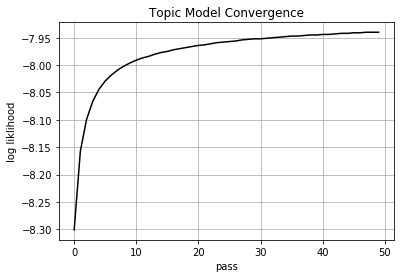

20 Topics:


[(0,
  '0.034*"Straße" + 0.022*"heben" + 0.019*"Junge" + 0.017*"Kopf" + 0.015*"Jungs" + 0.014*"Knast" + 0.014*"this" + 0.014*"fett" + 0.013*"Freundin" + 0.013*"Dinger"'),
 (1,
  '0.109*"ficke" + 0.096*"bitte" + 0.076*"Geben" + 0.065*"Auge_rot" + 0.041*"Ausweg" + 0.027*"Super" + 0.023*"Techno" + 0.021*"gekackt" + 0.017*"schmecken" + 0.016*"Wäsche"'),
 (2,
  '0.088*"nehm" + 0.045*"Scheisse" + 0.030*"Teil" + 0.016*"bitter" + 0.016*"name" + 0.015*"Yes" + 0.015*"eigentlich" + 0.013*"around" + 0.012*"Bitte_bitte" + 0.012*"Siedlung"'),
 (3,
  '0.028*"live" + 0.012*"Mann" + 0.012*"ein" + 0.009*"System" + 0.007*"draußen" + 0.007*"Leute" + 0.007*"Zahn" + 0.006*"hohl" + 0.006*"ficken" + 0.006*"lieb"'),
 (4,
  '0.068*"Nacht" + 0.054*"Schnapp" + 0.037*"Streets" + 0.030*"Geld" + 0.028*"tanz" + 0.023*"jed_Kind" + 0.017*"sehn" + 0.016*"Competition" + 0.016*"Audemars_Piguet" + 0.016*"beweisen"'),
 (5,
  '0.195*"siebzehn" + 0.101*"Rock" + 0.043*"geben" + 0.042*"lässt" + 0.040*"Hab" + 0.026*"DJ" + 0.024*

In [175]:
plot_passes(filename, passes)
print(f'{num_topics} Topics:')
lda_model.print_topics()

In [187]:
# Previous observation: Many meaningless topics -> fewer topics
filename = 'gensim_5.log'
create_logfile(filename)

num_topics = 7
chunksize = 1000
passes = 20
iterations = 10000


lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto'
)

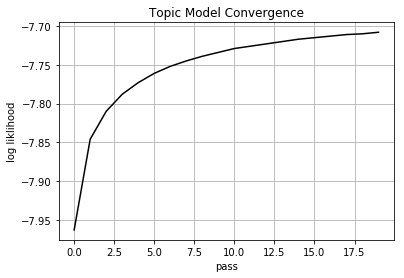

7 Topics:


[(0,
  '0.018*"Straße" + 0.011*"Block" + 0.011*"Junge" + 0.010*"fick" + 0.010*"Mutter" + 0.009*"Jungs" + 0.009*"Bruder" + 0.009*"Fick" + 0.009*"Gangster" + 0.008*"Bulle"'),
 (1,
  '0.047*"Baby" + 0.014*"lass" + 0.014*"komm" + 0.013*"weiß" + 0.011*"Lass" + 0.011*"Nacht" + 0.010*"mach" + 0.010*"Komm" + 0.009*"zieh" + 0.008*"high"'),
 (2,
  '0.016*"Leben" + 0.011*"Welt" + 0.009*"lieben" + 0.009*"sehen" + 0.008*"bleiben" + 0.008*"Weg" + 0.007*"weiß" + 0.007*"Gott" + 0.006*"Auge" + 0.006*"Herz"'),
 (3,
  '0.014*"Rapper" + 0.014*"yeah" + 0.013*"Bitch" + 0.013*"Rap" + 0.013*"Yeah" + 0.009*"mein" + 0.006*"Album" + 0.006*"Beat" + 0.006*"King" + 0.005*"Fan"'),
 (4,
  '0.025*"Dicka" + 0.020*"Geld" + 0.018*"Money" + 0.016*"Bitch" + 0.014*"Bitches" + 0.009*"Cash" + 0.009*"Gang" + 0.008*"Bruder" + 0.008*"Para" + 0.008*"High"'),
 (5,
  '0.020*"mal" + 0.009*"Mann" + 0.009*"eine" + 0.009*"mach" + 0.008*"sag" + 0.008*"Frau" + 0.007*"sagen" + 0.007*"komm" + 0.007*"wissen" + 0.006*"Geld"'),
 (6,
  '0.097*

In [213]:
plot_passes(filename, passes)
print(f'{num_topics} Topics:')
lda_model.print_topics()

# Very nice results. Topics:
# 0:Gangsterrap, 1: Frauen, 2: Liebe, Leben, 3: Hip-Hop, 4: Geld, Status, 5:?, 6: Englisch
# Filter english songs. Songs that contain the most common words from the english topic:
# "the", "you" und "and" will be removed

In [14]:
filename = 'gensim_6.log'
create_logfile(filename)

num_topics = 6
chunksize = 1000
passes = 30
iterations = 10000


lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto'
)

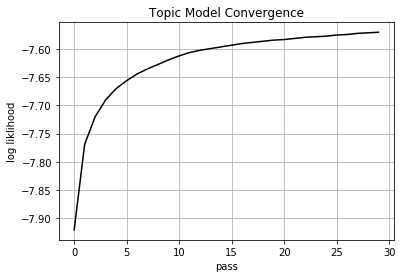

6 Topics:


[(0,
  '0.043*"the" + 0.014*"you" + 0.011*"down" + 0.010*"and" + 0.010*"Summer" + 0.009*"Eko" + 0.009*"for" + 0.008*"Shit" + 0.008*"fuck" + 0.007*"your" + 0.007*"Drip" + 0.006*"back" + 0.006*"like" + 0.006*"that" + 0.006*"Cem" + 0.006*"ready" + 0.006*"all" + 0.005*"hart" + 0.005*"love" + 0.005*"City"'),
 (1,
  '0.020*"Leben" + 0.014*"Welt" + 0.010*"sehen" + 0.010*"bleiben" + 0.009*"Weg" + 0.008*"Gott" + 0.008*"Herz" + 0.008*"Auge" + 0.007*"Kopf" + 0.007*"Hand" + 0.006*"leben" + 0.006*"Nacht" + 0.006*"stehen" + 0.006*"Traum" + 0.006*"Mensch" + 0.004*"Bruder" + 0.004*"sterben" + 0.004*"Licht" + 0.004*"liegen" + 0.004*"seh"'),
 (2,
  '0.012*"Rapper" + 0.010*"Rap" + 0.009*"mein" + 0.007*"komm" + 0.007*"mach" + 0.007*"Bitch" + 0.006*"sehen" + 0.006*"Junge" + 0.006*"Yeah" + 0.006*"fick" + 0.005*"Fick" + 0.005*"ein" + 0.005*"Arsch" + 0.004*"Nutte" + 0.004*"eine" + 0.004*"King" + 0.004*"kriegen" + 0.004*"mal" + 0.004*"Schwanz" + 0.004*"Guck"'),
 (3,
  '0.013*"Bruder" + 0.013*"Geld" + 0.009*"ma

In [15]:
plot_passes(filename, passes)
print(f'{num_topics} Topics:')
lda_model.print_topics(num_words=20)

# Still a lot of english; remove all english stop words

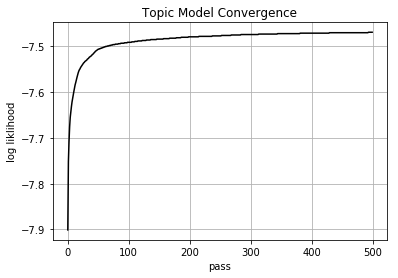

5 Topics:


[(0,
  '0.011*"Leben" + 0.009*"mal" + 0.008*"Welt" + 0.008*"sehen" + 0.008*"weiß" + 0.006*"lieben" + 0.006*"bleiben" + 0.005*"stehen" + 0.005*"denken" + 0.005*"Mann" + 0.005*"Weg" + 0.005*"sagen" + 0.005*"einfach" + 0.004*"Gott" + 0.004*"Auge" + 0.004*"Herz" + 0.004*"Hand" + 0.004*"Nacht" + 0.004*"weg" + 0.004*"eine"'),
 (1,
  '0.036*"Bitch" + 0.029*"yeah" + 0.019*"Money" + 0.016*"Bitches" + 0.016*"Yeah" + 0.013*"Geld" + 0.011*"ein" + 0.010*"Boy" + 0.010*"eine" + 0.008*"Boss" + 0.007*"Club" + 0.006*"Cash" + 0.005*"Farid" + 0.005*"Girl" + 0.005*"Bang" + 0.005*"Guck" + 0.005*"hol" + 0.005*"Gucci" + 0.005*"like" + 0.005*"Yeah_yeah"'),
 (2,
  '0.011*"Rapper" + 0.010*"mal" + 0.010*"Rap" + 0.009*"mein" + 0.009*"mach" + 0.009*"komm" + 0.007*"Junge" + 0.005*"Mann" + 0.005*"sehen" + 0.005*"fick" + 0.004*"King" + 0.004*"Arsch" + 0.004*"Leute" + 0.004*"Yeah" + 0.004*"Scheiß" + 0.004*"Fan" + 0.004*"Album" + 0.004*"kriegen" + 0.004*"machen" + 0.004*"Guck"'),
 (3,
  '0.012*"Bruder" + 0.012*"Geld" + 

In [17]:
filename = 'gensim_7.log'
create_logfile(filename)

num_topics = 5
chunksize = 1000
passes = 500
iterations = 10000


lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto'
)

plot_passes(filename, passes)
print(f'{num_topics} Topics:')
lda_model.print_topics(num_words=20)

# Use 300 passes

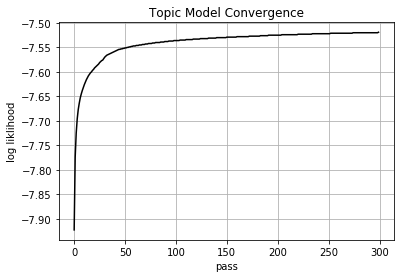

5 Topics:


[(0,
  '0.015*"Leben" + 0.010*"Welt" + 0.009*"sehen" + 0.008*"bleiben" + 0.007*"lieben" + 0.006*"Weg" + 0.006*"Gott" + 0.006*"Herz" + 0.005*"stehen" + 0.005*"Auge" + 0.005*"weiß" + 0.005*"leben" + 0.005*"Kopf" + 0.005*"denken" + 0.005*"Mensch" + 0.004*"Traum" + 0.004*"mein" + 0.004*"Nacht" + 0.004*"Mann" + 0.004*"Kind" + 0.004*"Mama" + 0.004*"mal" + 0.004*"Freund" + 0.004*"Bruder" + 0.004*"hören"'),
 (1,
  '0.012*"Bruder" + 0.010*"Geld" + 0.007*"Straße" + 0.007*"mach" + 0.006*"Benz" + 0.006*"Bra" + 0.006*"Jungs" + 0.005*"Block" + 0.005*"Scheine" + 0.005*"Kopf" + 0.005*"geben" + 0.005*"Para" + 0.004*"Bratan" + 0.004*"eine" + 0.004*"Digga" + 0.004*"Gang" + 0.004*"Fick" + 0.004*"fick" + 0.004*"weg" + 0.004*"Haze" + 0.004*"Bulle" + 0.003*"voll" + 0.003*"Knast" + 0.003*"zieh" + 0.003*"paar"'),
 (2,
  '0.019*"mal" + 0.017*"Baby" + 0.012*"weiß" + 0.011*"komm" + 0.011*"mach" + 0.010*"sag" + 0.008*"lass" + 0.007*"eine" + 0.007*"wissen" + 0.007*"Komm" + 0.007*"sagen" + 0.007*"Frau" + 0.006*"bitt

In [55]:
filename = 'gensim_8.log'
create_logfile(filename)

num_topics = 5
chunksize = 1000
passes = 300
iterations = 10000
random_state = 973525


lda_model = LdaModel(
         corpus=corpus,
         id2word=id2word,
         num_topics=num_topics,
         passes=passes,
         iterations=iterations,
         chunksize=chunksize,
         alpha='auto',
         eta='auto',
         random_state=random_state
)

plot_passes(filename, passes)
print(f'{num_topics} Topics:')
lda_model.print_topics(num_words=25)

In [65]:
# Coherence Score


Coherence Score:  0.4128085847617268


In [77]:
# Get topic distributions of some songs
def get_topic_from_song(title):
    doc = docs[all_songs.index[all_songs['Title']==title][0]]
    song_corpus = dictionary.doc2bow(doc)
    prob_distribution = lda_model[song_corpus]
    topic = max(prob_distribution,key=itemgetter(1))[0]
    if topic == 0:
        return 'Leben & Lieben'
    elif topic == 1:
        return 'Kriminalität'
    elif topic == 2:
        return 'Sex & Party'
    elif topic == 3:
        return 'Status'
    else:
        return 'Rap'

In [119]:
get_topic_from_song('Funky')

'Sex & Party'

In [121]:
def get_coherence_score():
    coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda